# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Imports

from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel
from medclip import MedCLIPProcessor
import os
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image

N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

#current_directory = os.getcwd()
#save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
#os.makedirs(save_path, exist_ok=True)
#model_path = os.path.join(save_path, 'model_wieghts.pt')
model_path = 'C:/Users/user02/PycharmProjects/medclipcap/11_MedClipCap/MedClipCap/coco_train/coco_prefix-010.pt'


In [2]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [71]:
#@title Caption prediction

def generate_beam(
    model,
    tokenizer,
    beam_size: int = 5,
    prompt=None,
    embed=None,
    # entry_length=67,  # maximum number of words
    entry_length=50,  # maximum number of words
    temperature=1.,
    #stop_token: str = '.',
    stop_token: str = '<|endoftext|>'
    ):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
    model,
    tokenizer,
    tokens=None,
    prompt=None,
    embed=None,
    entry_count=1,
    # entry_length=67,  # maximum number of words
    entry_length=100,  # maximum number of words
    top_p=0.8,
    temperature=1.5,     # 1.
    #stop_token: str = '.',
    stop_token: str = '<|endoftext|>'
    ):
    
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]  # 50256
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):   # trange는 tqdm이랑 비슷한 메서드
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                print(next_token)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():       # tensor.item() : 토치 텐서 내의 값만 뽑기
                    print("스돕!!!", next_token.item())         # 지금 stop token이 안 나오고 있음
                    break
                #print(next_token)
                #if stop_token_index == 50256:
                #    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            print(output_list)
            print(output_text)
            generated_list.append(output_text)

    return generated_list[0]

In [72]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [73]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
preprocess = MedCLIPProcessor()
clip_model.from_pretrained()
clip_model.cuda()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.tra

load model weight from: ./pretrained/medclip-vit


In [74]:
#@title Load model weights


prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


In [75]:
print(model)

ClipCaptionModel(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (clip_project): MLP(
    (model

In [76]:
df_ = pd.read_csv("C:/Users/user02/PycharmProjects/medclipcap/11_MedClipCap/df_finetune.csv")
df, val_df = train_test_split(df_, test_size=0.1, shuffle=False)

image_num = 201
image_name = val_df.iloc[image_num]['image']
gt = val_df.iloc[image_num]['caption']


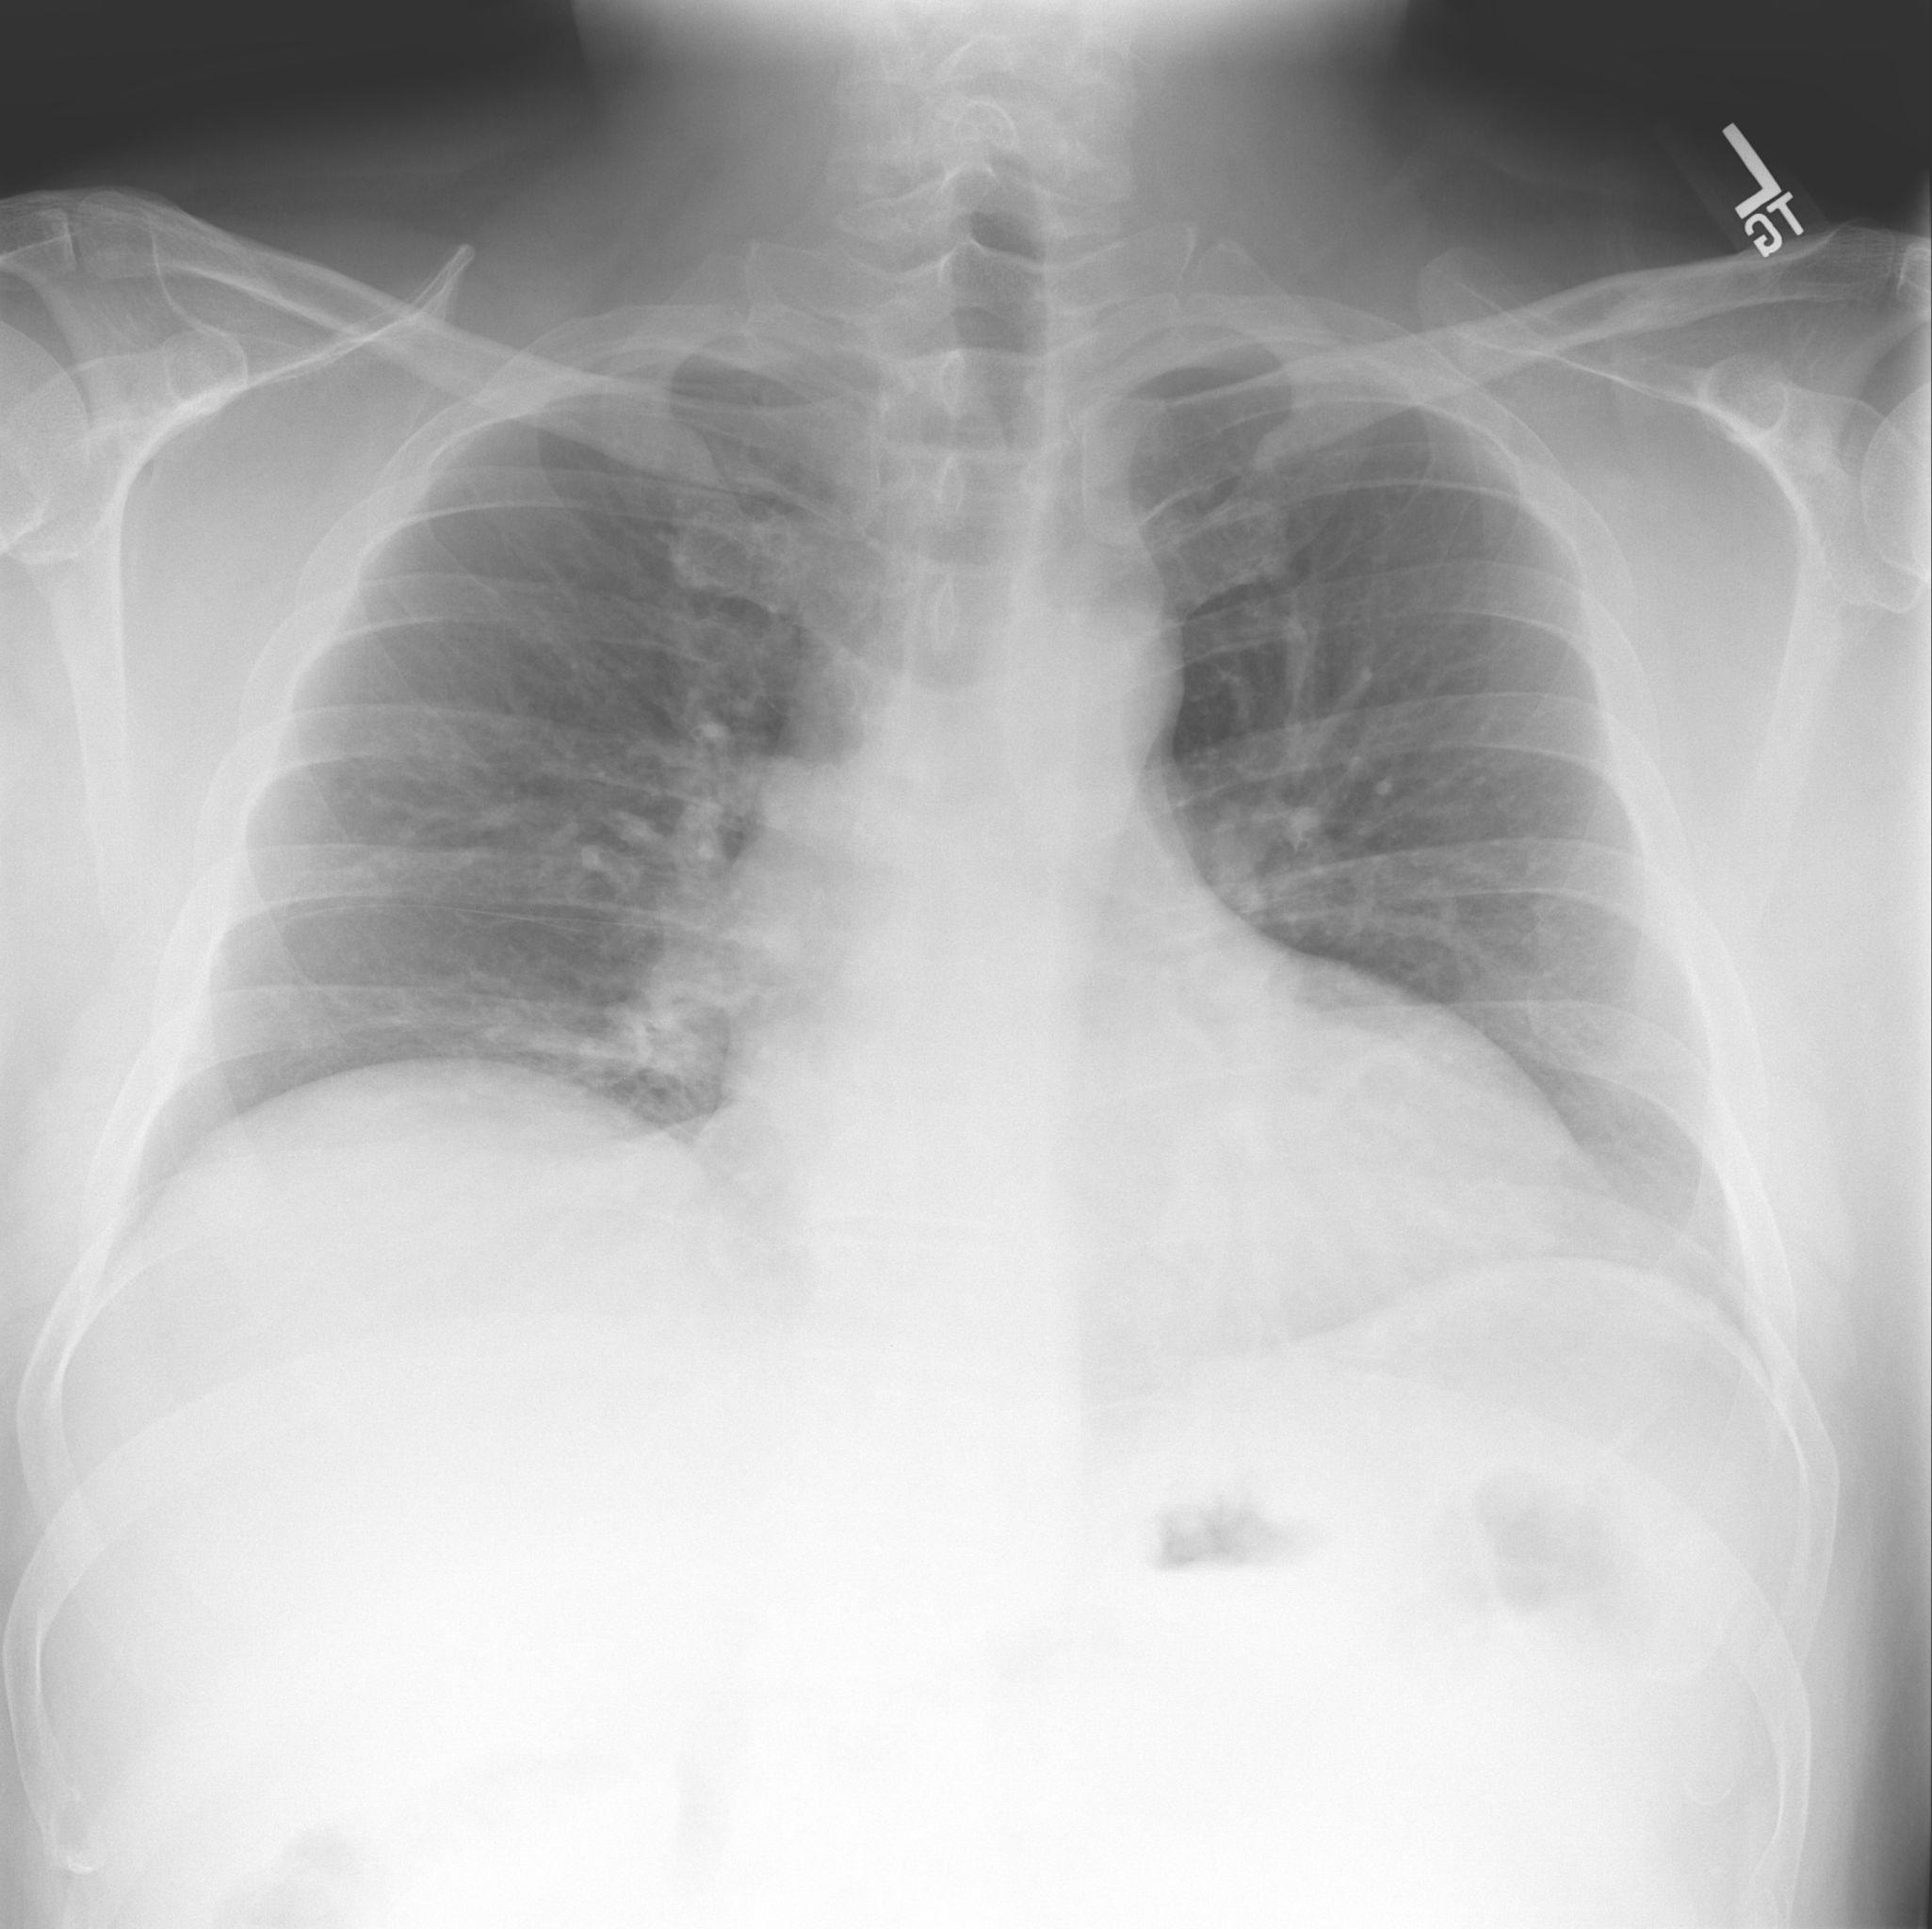

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1169]], device='cuda:0')
tensor([[2612]], device='cuda:0')
tensor([[318]], device='cuda:0')
tensor([[3487]], device='cuda:0')
tensor([[287]], device='cuda:0')
tensor([[2546]], device='cuda:0')
tensor([[13]], device='cuda:0')
tensor([[262]], device='cuda:0')
tensor([[16957]], device='cuda:0')
tensor([[459]], device='cuda:0')
tensor([[259]], device='cuda:0')
tensor([[388]], device='cuda:0')
tensor([[318]], device='cuda:0')
tensor([[49733]], device='cuda:0')
tensor([[45543]], device='cuda:0')
tensor([[13]], device='cuda:0')
tensor([[262]], device='cuda:0')
tensor([[21726]], device='cuda:0')
tensor([[389]], device='cuda:0')
tensor([[1598]], device='cuda:0')
tensor([[13]], device='cuda:0')
tensor([[645]], device='cuda:0')
tensor([[14352]], device='cuda:0')
tensor([[4369]], device='cuda:0')
tensor([[13]], device='cuda:0')
tensor([[645]], device='cuda:0')
tensor([[20085]], device='cuda:0')
tensor([[12183]], device='cuda:0')
tensor([[39381]], device='cuda:0')
tensor([[389]], device='c

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

tensor([[13]], device='cuda:0')
tensor([[764]], device='cuda:0')
tensor([[645]], device='cuda:0')
tensor([[20085]], device='cuda:0')
tensor([[12183]], device='cuda:0')
tensor([[39381]], device='cuda:0')
tensor([[389]], device='cuda:0')
tensor([[9555]], device='cuda:0')
tensor([[13]], device='cuda:0')
tensor([[764]], device='cuda:0')
[1169, 2612, 318, 3487, 287, 2546, 13, 262, 16957, 459, 259, 388, 318, 49733, 45543, 13, 262, 21726, 389, 1598, 13, 645, 14352, 4369, 13, 645, 20085, 12183, 39381, 389, 1775, 13, 645, 20085, 12183, 39381, 389, 9555, 13, 645, 14352, 4369, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764]
the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. no acute dise

In [77]:
#@title Inference

use_beam_search = False #@param {type:"boolean"}

image = PIL.Image.open(image_name)
inputs = preprocess(
    text=["opacity left",],
    images=image,
    return_tensors="pt",
    padding=True
    )
display(image)

with torch.no_grad():
    outputs = clip_model(**inputs)
    prefix = outputs['img_embeds'].to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print('generated : ', generated_text_prefix)
print('\n')
print('ground trueth : ', gt)


In [83]:
print(tokenizer.decode([1169, 2612, 16957, 49733, 764]))

print(tokenizer.decode([1169, 2612, 318, 3487, 287, 2546, 13, 262, 16957, 459, 259, 388, 318,
                        49733, 45543, 13, 262, 21726, 389, 1598, 13, 645, 14352, 4369, 13, 645,
                        20085, 12183, 39381, 389, 1775, 13, 645, 20085, 12183, 39381, 389, 9555,
                        13, 645, 14352, 4369, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764,
                        645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389,
                        9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645, 20085, 12183,
                        39381, 389, 9555, 13, 764, 645, 20085, 12183, 39381, 389, 9555, 13, 764, 645,
                        20085, 12183, 39381, 389, 9555, 13, 764]))



the heart medi unrem.
the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. no acute disease. no displaced rib fractures are seen. no displaced rib fractures are demonstrated. no acute disease.. no displaced rib fractures are demonstrated.. no displaced rib fractures are demonstrated.. no displaced rib fractures are demonstrated.. no displaced rib fractures are demonstrated.. no displaced rib fractures are demonstrated.. no displaced rib fractures are demonstrated.. no displaced rib fractures are demonstrated..


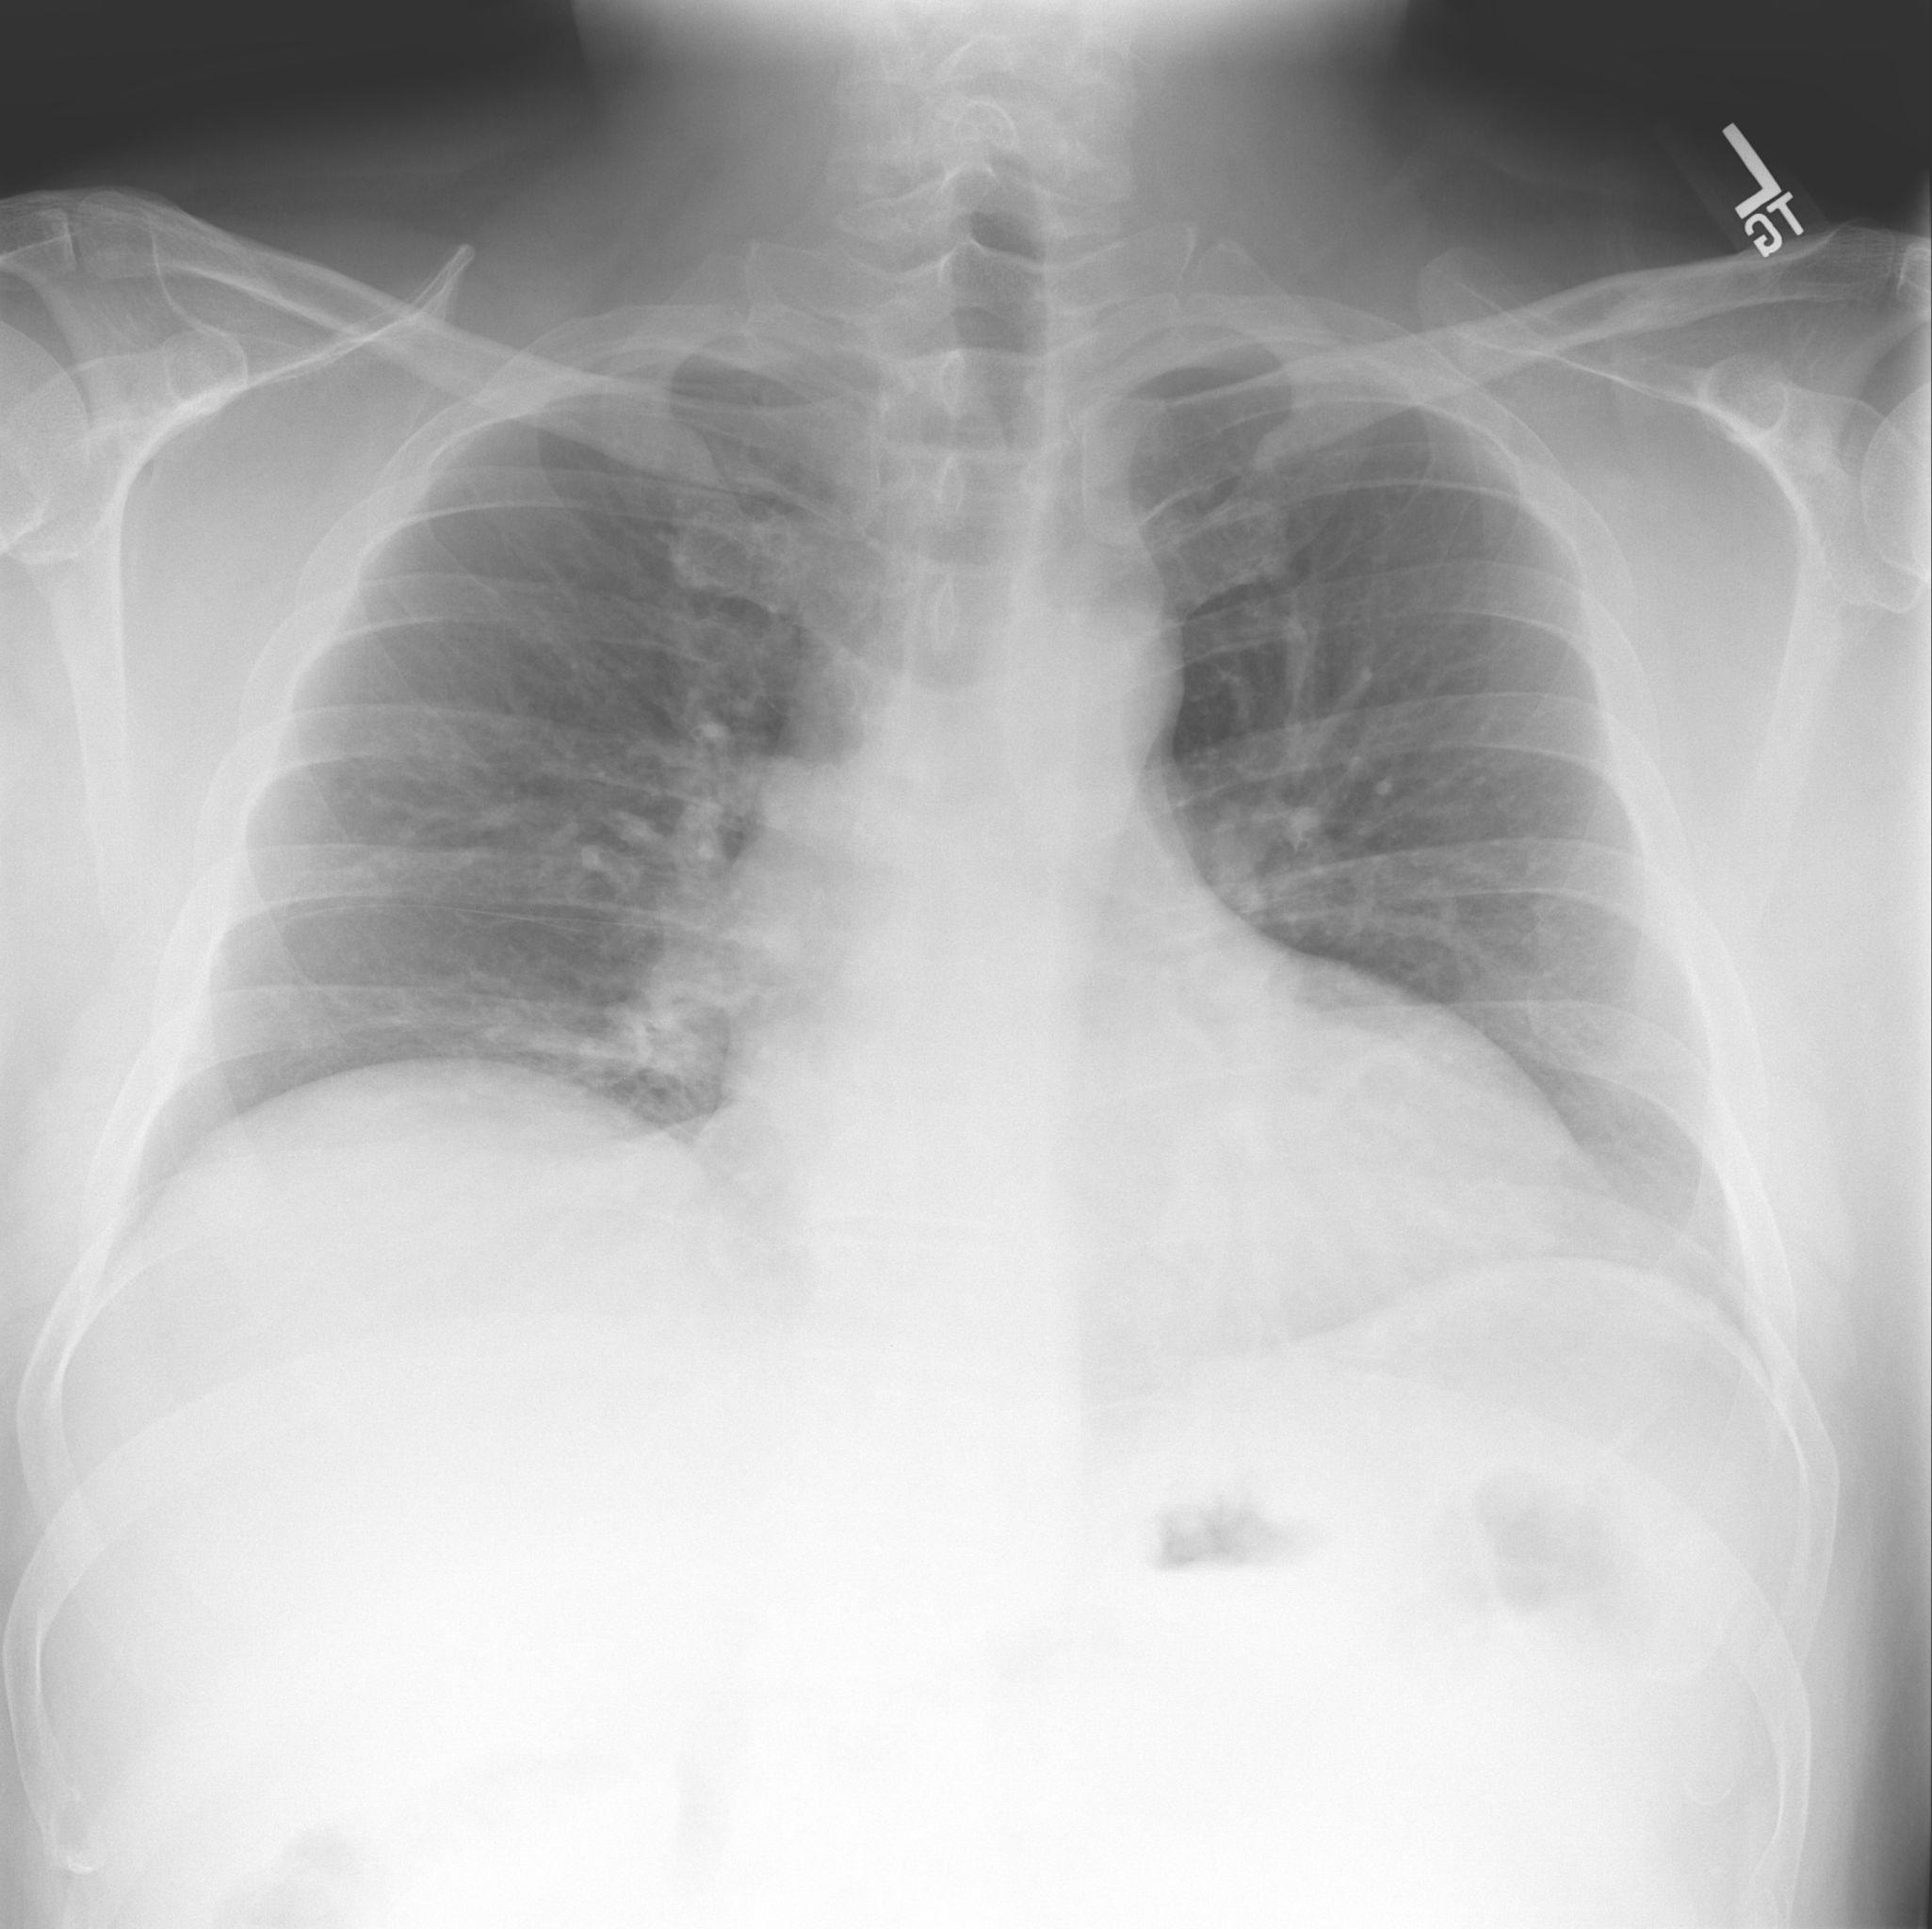



generated :  the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thorax are without acute abnormality


ground trueth :  cardio mediastinal silhouette, pulmonary vascular pattern are within normal limits. mildly low lung volumes. no focal infiltrate, pleural effusion or pulmonary edema. no pneumothorax. no acute cardiopulmonary disease.


In [10]:
#@title Inference

use_beam_search = True #@param {type:"boolean"}

image = PIL.Image.open(image_name)
inputs = preprocess(
    text=["opacity left",],
    images=image,
    return_tensors="pt",
    padding=True
    )
display(image)

with torch.no_grad():
    outputs = clip_model(**inputs)
    prefix = outputs['img_embeds'].to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print('generated : ', generated_text_prefix)
print('\n')
print('ground trueth : ', gt)

In [11]:
print(image_name)

C:/Users/user02/OpenDatasets/IU_X-ray/images/images_normalized/3714_IM-1856-1001.dcm.png


In [12]:
# a = pd.read_pickle('C:/Users/user02/PycharmProjects/medclipcap/11_MedClipCap/ClipCap/data/coco/oscar_split_ViT-B_32_train.pkl')
# b = a['captions']
# c = a['clip_embedding']

In [13]:
# print(a.keys())

In [14]:
# from transformers import GPT2Tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [15]:
# print(tokenizer.pad_token)

In [16]:
# print(tokenizer.eos_token)

In [17]:
# print(tokenizer("hi. <|endoftext|>"))

In [18]:
# print(tokenizer("hi.<|endoftext|>"))